In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc 
import skimage as ski
import equinox as eqx
import jax 
import jax.scipy as jsp
import jax.numpy as jnp
import helper as hlp
import dm_pix
from tqdm import tqdm
import optax 
import astra 
from functools import partial
from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2

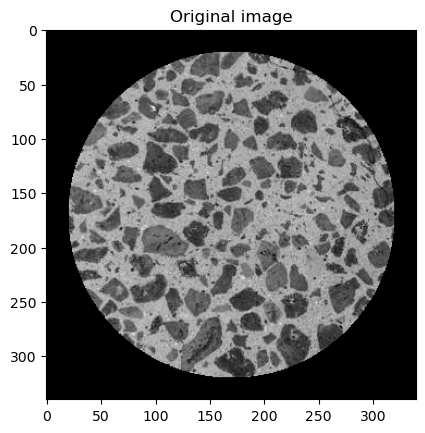

In [2]:
# working img
img = ski.io.imread('data/img/concrete_surface.jpeg').astype(np.float32)
img = ski.color.rgb2gray(img)[:340, :340]

#normalize
img = (img - img.min()) / np.ptp(img) 

# add poisson noise
# noise_img = ski.util.random_noise(image=model(img_gt), mode="poisson").clip(0, None)

# circular clip img 
disk_img = np.zeros(img.shape)
disk_coord = ski.draw.disk((img.shape[0]//2,img.shape[1]//2), 150)
disk_img[disk_coord] = 1
img = img*disk_img

plt.imshow(img, cmap= 'gray')
plt.title('Original image')
plt.show()


In [3]:
def gen_img(shape, pattern, nbr_patterns ,seed, texture_scale, show = True): #shape : tuple in inches cree une img avec 100 pixel par inches #add nbr nbr pattern en parametre + add docs # cree 1000 img de chaque entre 5 60
    """
    Generate 2D grayscale image with randomly oriented textured pattern.

    Parameters
    ----------
    shape: tuple[int, int]
        (height, width) Shape of the img in inches. 1 inches will be represented by 100 pixels
    pattern: str
        Choice of pattern in the img. Can be either 'ellipse', 'rectangle', 'triangle' or 'mix'
    nbr_patterns: int
        nbr of patterns to add inside the img
    seed: int
        seed for the reproducibility
    texture_scale: int or str
        texture_scale = 0 means no texture, texture_scale = 1 means fully textured. Also possible to have a mix of texture scale by setting texture_scale='mix'
    show: bool = True
        to display the resulting img

    Returns
    -------
    img: ndarray
        (height, width)
    """
    # init empty img
    fig, ax = plt.subplots(figsize = shape, dpi = 100)
    width, height = fig.get_size_inches()*fig.dpi
    img = np.zeros((int(width),int(height)))
    #add patterns
    mix_choice = None
    rng = np.random.default_rng(seed)  
    rng_texture = np.random.default_rng(seed + 10)  
    for i in range(nbr_patterns):
        # define pattern
        center_x = rng.uniform(0.1*height, height-0.1*height)
        center_y = rng.uniform(0.1*width, width- 0.1*width)
        angle = rng.uniform(-np.pi,np.pi)
        if pattern == 'mix':
            mix_choice =  rng.integers(1,4)
 
        if pattern == 'ellipse' or mix_choice == 1: 
            radius_x, radius_y = rng.uniform(5, 41, 2)
            rr, cc = ski.draw.ellipse(center_x, center_y, radius_x ,radius_y, shape= (int(width), int(height)), rotation= angle)

        if pattern == 'rectangle' or mix_choice == 2:
            rect_width = rng.uniform(10, 70)
            rect_height = rng.uniform(10, 50)
            dx = rect_width/2
            dy = rect_height/2
            corners = np.array([[-dx,-dy], [dx, -dy], [dx, dy], [-dx, dy]])

            # Rotate corners
            R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle),  np.cos(angle)]])
            corners = corners@R + (center_x, center_y)

            rr, cc = ski.draw.polygon(corners[:, 0], corners[:, 1], shape= (int(width), int(height)))
        if pattern == 'triangle'  or mix_choice == 3:
            tri_width = rng.uniform(20, 70)
            tri_height = rng.uniform(20, 50)
            dx =  tri_width/2
            third_point_x = rng.uniform(-2*tri_height, 2*tri_height)
            corners = np.array([[-dx,0], [dx, 0], [third_point_x, tri_height]])

            
            # Rotate corners
            R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle),  np.cos(angle)]])
            corners = corners@R + (center_x, center_y)

            rr, cc = ski.draw.polygon(corners[:, 0], corners[:, 1], shape= (int(width), int(height)))

        
        # Generate textured pattern
        if texture_scale == 'mix':
            scale = rng_texture.uniform(0,1)
        else:
            scale = texture_scale
        
        texture = 1 - rng_texture.uniform(0, 1, img.shape)*scale
        
        # Smoothen the img slightly to make cells look more natural
        sigma_0 = rng_texture.uniform(1,2)
        sigma_1 = rng_texture.uniform(1,2)
        texture = sc.ndimage.gaussian_filter1d(texture, sigma=sigma_0, axis = 0) 
        texture = sc.ndimage.gaussian_filter1d(texture, sigma=sigma_1, axis = 1) 

        # rotate smoothen texture to make img more natural
        angle = rng_texture.uniform(0, 180)
        texture = sc.ndimage.rotate(texture, angle, reshape=False)

        img[rr, cc] = texture[rr,cc]
            
    # Smoothen the img slightly to make cells look more natural
    # img = sc.ndimage.gaussian_filter1d(img, sigma=1, axis = 0) 
    # img = sc.ndimage.gaussian_filter1d(img, sigma=3, axis = 1) 

    # circular clip img 
    disk_img = np.zeros(img.shape)
    disk_coord = ski.draw.disk((img.shape[0]//2,img.shape[1]//2), min(img.shape)/2*0.9)
    disk_img[disk_coord] = 1
    img = img*disk_img


    # Normalize
    img = (img - img.min()) / np.ptp(img)

    if show: 
        ax.imshow(img, cmap= 'gray')
        plt.show()
    return img 


In [4]:
def gen_dataset(shape, pattern, nbr_img, output_dir):
    """
    Generate Dataset of 2D grayscale image created from gen_img(...) function. Save resulting images in RGBA in .png format 

    Parameters
    ----------
    shape: tuple[int, int]
        (height, width) Shape of the img in inches. 1 inches will be represented by 100 pixels
    pattern: str
        Choice of pattern in the img. Can be either 'ellipse', 'rectangle', 'triangle', 'mix', or 'all'. pattern = 'all' will save images from all categories 
    nbr_img: int
        nbr of images to create for the chosen pattern. Note that if pattern = 'all', it will create nbr_img images per pattern. 
    output_dir: str
        directory where images will be saved
    Returns
    -------
    None. Images are saved in output_dir in RGBA in .png format
    """
    # create dir to save images
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    seed = 1
    # uniform texture scale 
    list_texture_scale = np.linspace(0,1,nbr_img)
    for i in range(nbr_img):
        if pattern == 'all':
            pattern_list = ['rectangle', 'ellipse', 'triangle', 'mix']

        elif  pattern == 'triangle':
            pattern_list = ['triangle']

        elif  pattern == 'rectangle':
            pattern_list = ['rectangle']

        elif  pattern == 'ellipse':
            pattern_list = ['ellipse']
        
        elif  pattern == 'mix':
            pattern_list = ['mix']

        for pattern_choice in pattern_list:
            # create img
            print(f"Generating image {seed} over {len(pattern_list)*nbr_img} images", end='\r')
            img = gen_img(shape=shape, pattern=pattern_choice, nbr_patterns=100, seed=seed, texture_scale=list_texture_scale[i], show= False)
            
            # savec img
            img_name = pattern_choice + '_' + str(i) + '.png'
            plt.imsave(output_dir/img_name, img, cmap="gray")
            seed +=1


In [7]:
gen_dataset(shape=(5,5), pattern='ellipse', nbr_img=5, output_dir= 'test')

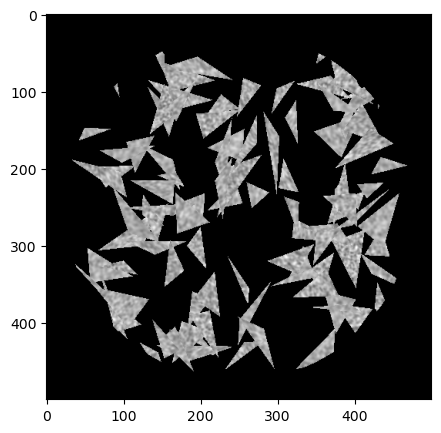

(500, 500)

In [5]:
gen_img(shape=(5,5), pattern='triangle', nbr_patterns=100, seed=10, texture_scale=1).shape

# CNR

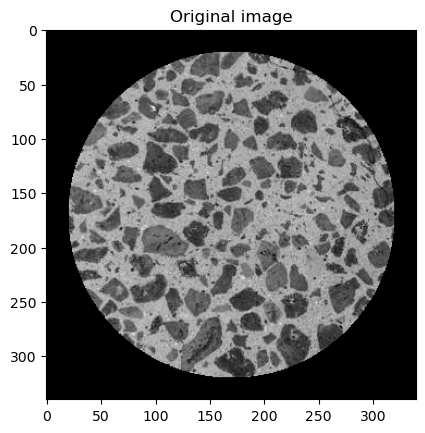

In [12]:
# working img
img = ski.io.imread('data/img/concrete_surface.jpeg').astype(np.float32)
img = ski.color.rgb2gray(img)[:340, :340]

#normalize
img = (img - img.min()) / np.ptp(img) 

# add poisson noise
# noise_img = ski.util.random_noise(image=model(img_gt), mode="poisson").clip(0, None)

# circular clip img 
disk_img = np.zeros(img.shape)
disk_coord = ski.draw.disk((img.shape[0]//2,img.shape[1]//2), 150)
disk_img[disk_coord] = 1
img = img*disk_img

plt.imshow(img, cmap= 'gray')
plt.title('Original image')
plt.show()


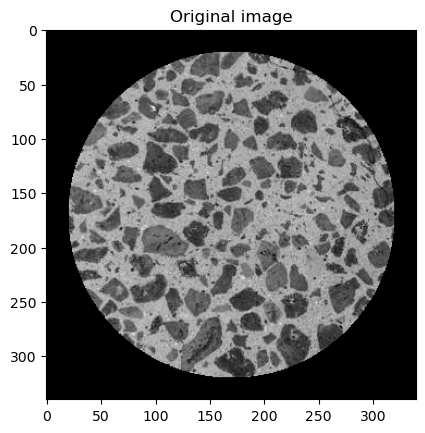

In [ ]:
img = img[100:100+10]

plt.imshow(img, cmap= 'gray')
plt.title('Original image')
plt.show()

In [ ]:
def CNR(img, case, size = 10, highlight = False):
    img_copy = img.copy()

    # select index area
    if case == 0:
        # foreground
        x1 = 95
        y1 = 190

        # background
        x2 =115
        y2 = 175

    if case == 1:
        # foreground
        x1 = 222
        y1 = 292

        # background
        x2 = 237
        y2 = 264

    if case == 2:
        # foreground
        x1 = 205
        y1 = 225

        # background
        x2 = 222
        y2 = 204

    
    # compute CNR
    area1 = img_copy[y1:y1+size, x1:x1+size]
    mean_area1 = area1.mean()
    # print(f'mean foreground {mean_area1}')
    
    area2 = img_copy[y2:y2+size, x2:x2+size]
    mean_area2 = area2.mean()
    # print(f'mean background {mean_area2}')

    std_noise = area2.std()
    # print(f'std noise {std_noise}')

    CNR = np.abs(mean_area1 - mean_area2) / std_noise
    # print(f'CNR {CNR}' )

    if highlight:
        # highlight areas 
        img_copy[y1:y1+size, x1:x1+size] = 1
        img_copy[y2:y2+size, x2:x2+size] = 1
        return img_copy, CNR


    return CNR

In [19]:
img2, _ = CNR(img, case=1)

plt.imshow(img2, cmap= 'gray')
plt.title('Original image')
plt.show()

TypeError: cannot unpack non-iterable numpy.float64 object

In [ ]:
# fbp only
high_noise_fbp =reconst_high_noise_list[2]
low_noise_fbp = reconst_noise_list[4]

# model based
recon_TV_low # 04:31
recon_TV_high # 05:29

# post proc
med_fbp_low_noised # <1s
med_fbp_high_noised # <1s

maxim_fpb_low_noised # 17 s 16
maxim_fpb_high_noised # 16s 15

# pre proc
cos_fbp_low_noised # <1
cos_fbp_high_noised  # <1

maxim_fbp_low # 8 9 9
maxim_fbp_high # 13 13 12
